# Loading the Libraries

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.5 MB/s 
     |████████████████████████████████| 189 kB 33.7 MB/s 
     |████████████████████████████████| 1.2 MB 20.5 MB/s 
     |████████████████████████████████| 46 kB 2.1 MB/s 
     |████████████████████████████████| 56 kB 3.0 MB/s 
     |████████████████████████████████| 51 kB 215 kB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *
from fastai.vision.widgets import *

# Gathering the Data

In [16]:
key = os.environ.get('AZURE_SEARCH_KEY', 'xxx')
key

'885519e690664fbf85a6393f68dd3070'

In [17]:
search_images_bing

<function fastbook.search_images_bing>

In [18]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

150

In [19]:
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [20]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

Path('images/grizzly.jpg')

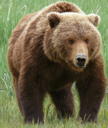

In [21]:
im = Image.open(dest)
im.to_thumb(128,128)

In [22]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [23]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [24]:
fns = get_image_files(path)
fns

(#439) [Path('bears/black/00000123.jpg'),Path('bears/black/00000047.jpg'),Path('bears/black/00000019.jpg'),Path('bears/black/00000062.jpg'),Path('bears/black/00000038.JPG'),Path('bears/black/00000048.jpg'),Path('bears/black/00000106.JPG'),Path('bears/black/00000099.jpg'),Path('bears/black/00000052.jpg'),Path('bears/black/00000023.jpg')...]

In [25]:
failed = verify_images(fns)
failed

(#1) [Path('bears/teddy/00000048.png')]

In [26]:
failed.map(Path.unlink);

## From Data to DataLoaders

DataLoaders is a thin class that just stores whatever DataLoader objects you pass to it, and makes them available as train and valid. Although it's a very simple class, it's very important in fastai: it provides the data for your model. 

In [27]:
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])

In [28]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [29]:
dls = bears.dataloaders(path)

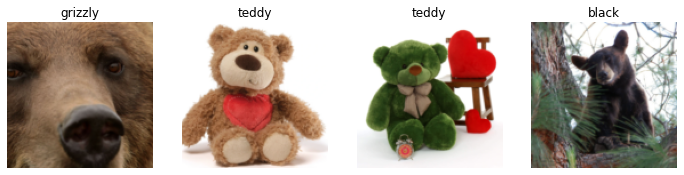

In [30]:
dls.valid.show_batch(max_n=4, nrows=1)

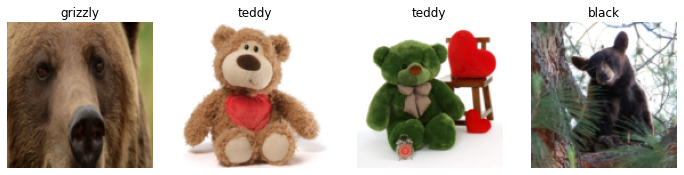

In [31]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

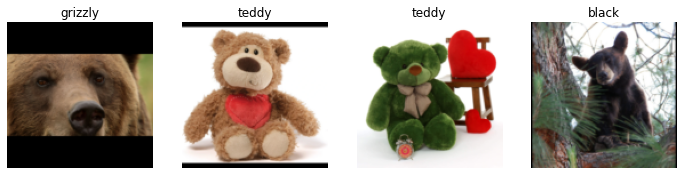

In [32]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

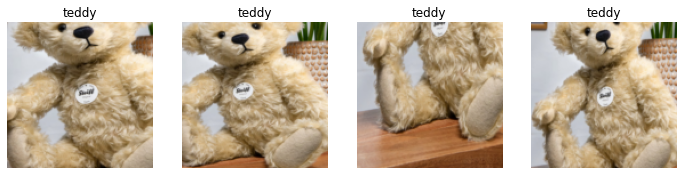

In [33]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

## Data Augmentation

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


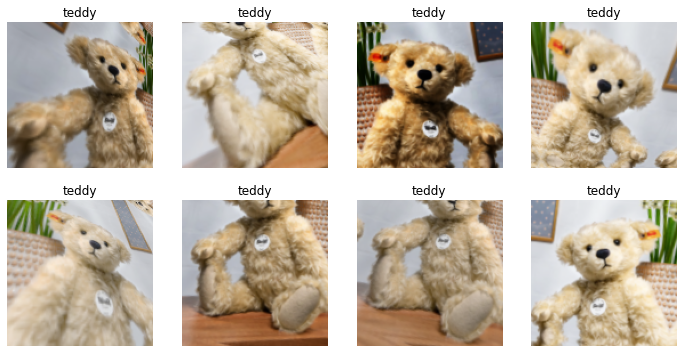

In [34]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [35]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

# Training

In [36]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.085610,0.082877,0.022989,00:28


epoch,train_loss,valid_loss,error_rate,time
0,0.166569,0.027264,0.011494,00:29
1,0.114164,0.008968,0.000000,00:29
2,0.081430,0.003936,0.000000,00:29
3,0.065742,0.003758,0.000000,00:30


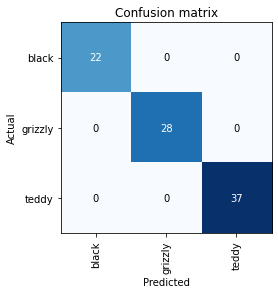

In [37]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

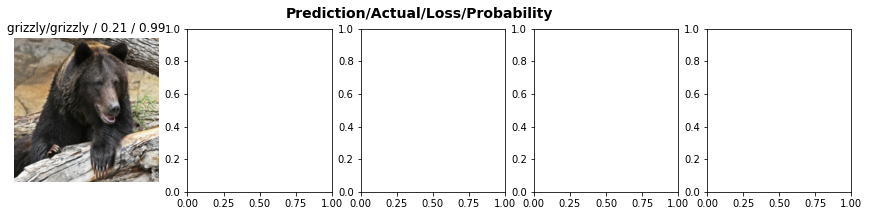

In [38]:
interp.plot_top_losses(5, nrows=1)

In [39]:
cleaner = ImageClassifierCleaner(learn)
cleaner

# Saving model for production

In [40]:
learn.export()

In [41]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [42]:
learn_inf = load_learner(path/'export.pkl')

In [43]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', TensorBase(1), TensorBase([3.4877e-06, 1.0000e+00, 1.8238e-07]))

In [44]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']